C:\Users\gongchencan\AppData\Local\Temp\ipykernel_17248\2943709612.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['批发价格(元/千克)'].fillna(df_final['批发价格(元/千克)'].median(), inplace=True)


数据加载与合并成功！


C:\Users\gongchencan\AppData\Local\Temp\ipykernel_17248\2943709612.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_daily_category_summary = df_final.groupby(['销售日期', '分类名称']).apply(
C:\Users\gongchencan\AppData\Local\Temp\ipykernel_17248\2943709612.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_binned = df_category.groupby('加成率区间').agg(


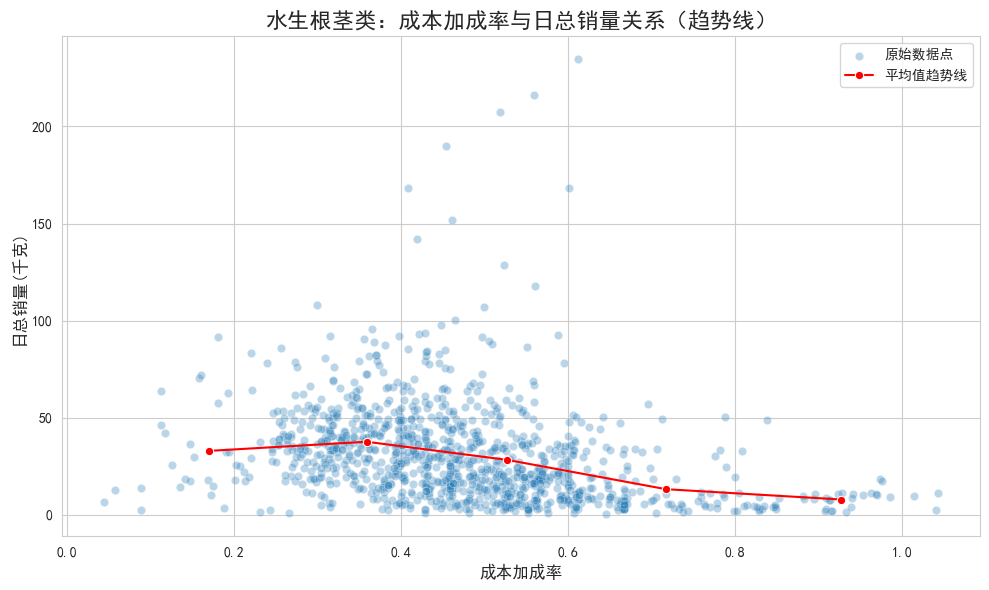

C:\Users\gongchencan\AppData\Local\Temp\ipykernel_17248\2943709612.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_binned = df_category.groupby('加成率区间').agg(


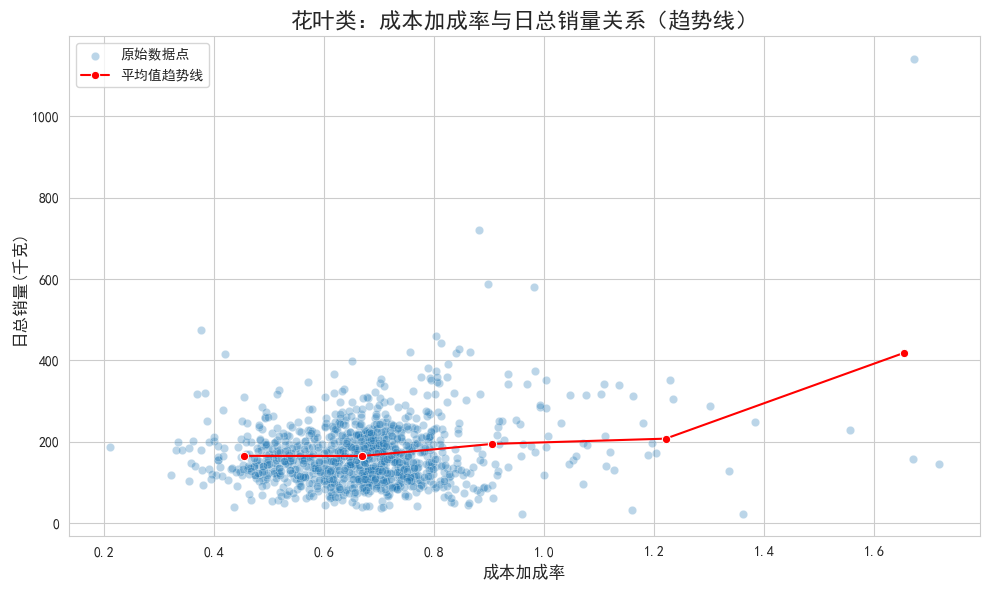

C:\Users\gongchencan\AppData\Local\Temp\ipykernel_17248\2943709612.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_binned = df_category.groupby('加成率区间').agg(


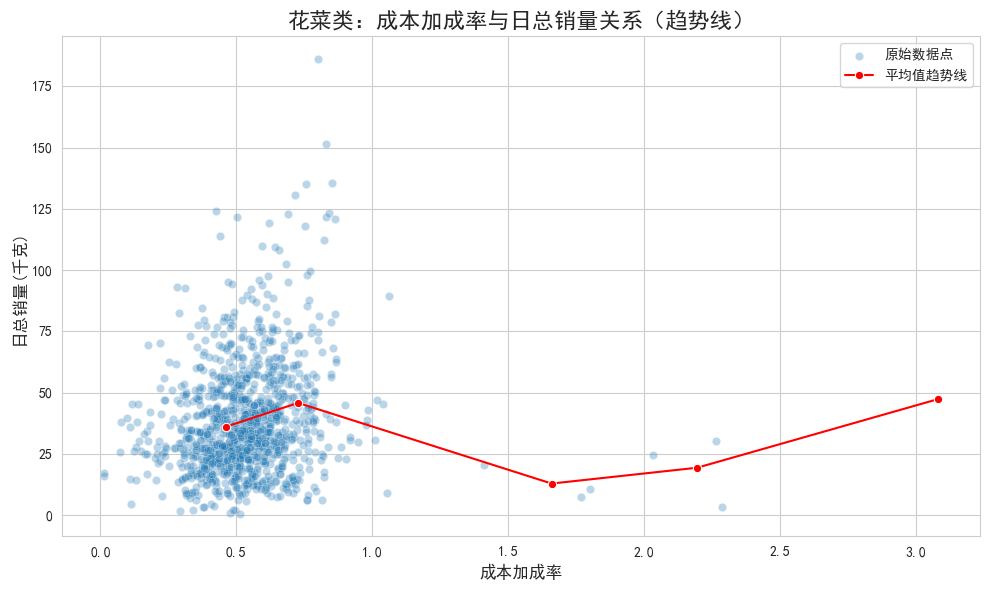

C:\Users\gongchencan\AppData\Local\Temp\ipykernel_17248\2943709612.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_binned = df_category.groupby('加成率区间').agg(


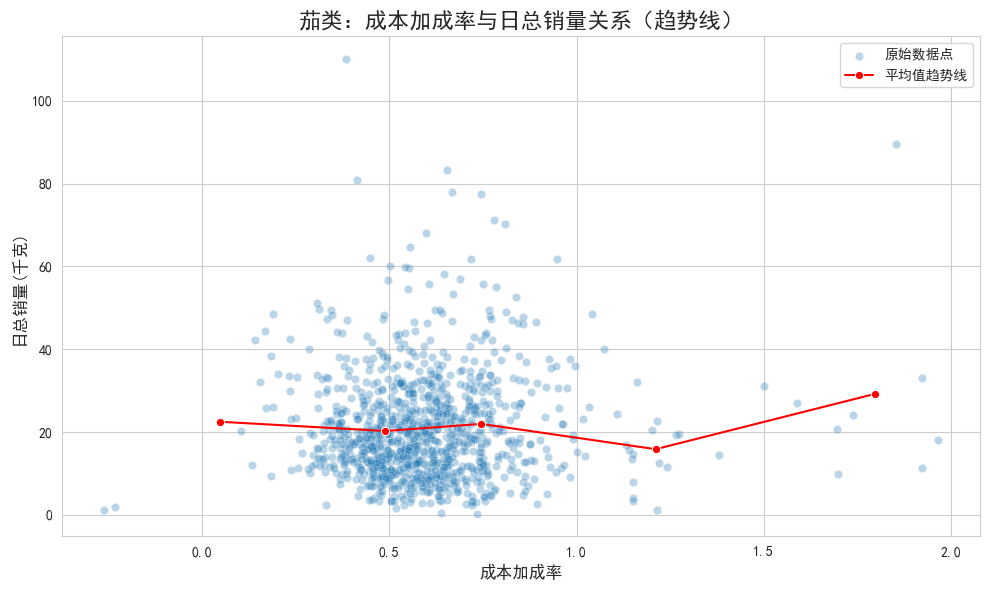

C:\Users\gongchencan\AppData\Local\Temp\ipykernel_17248\2943709612.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_binned = df_category.groupby('加成率区间').agg(


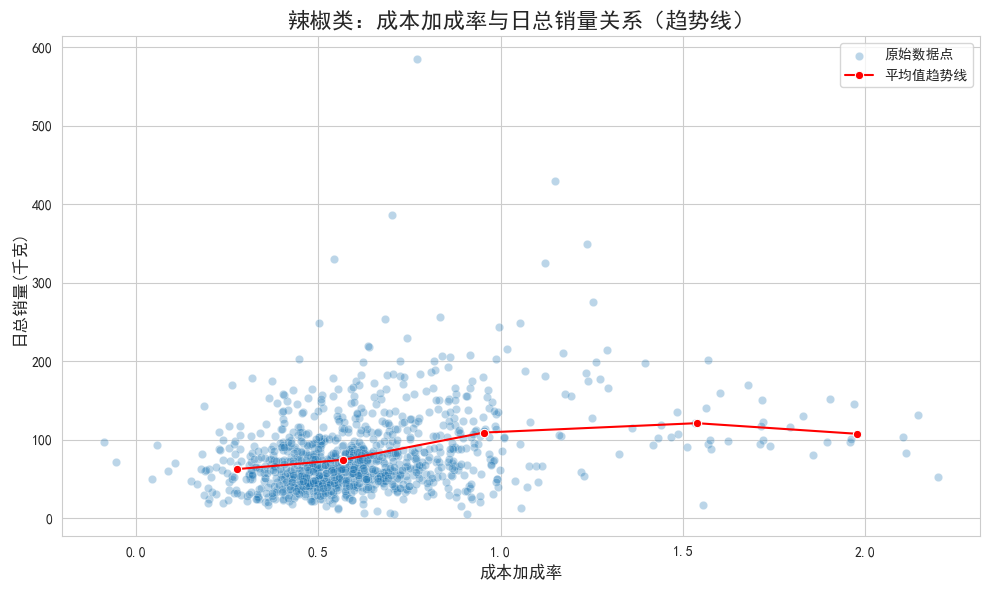

C:\Users\gongchencan\AppData\Local\Temp\ipykernel_17248\2943709612.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_binned = df_category.groupby('加成率区间').agg(


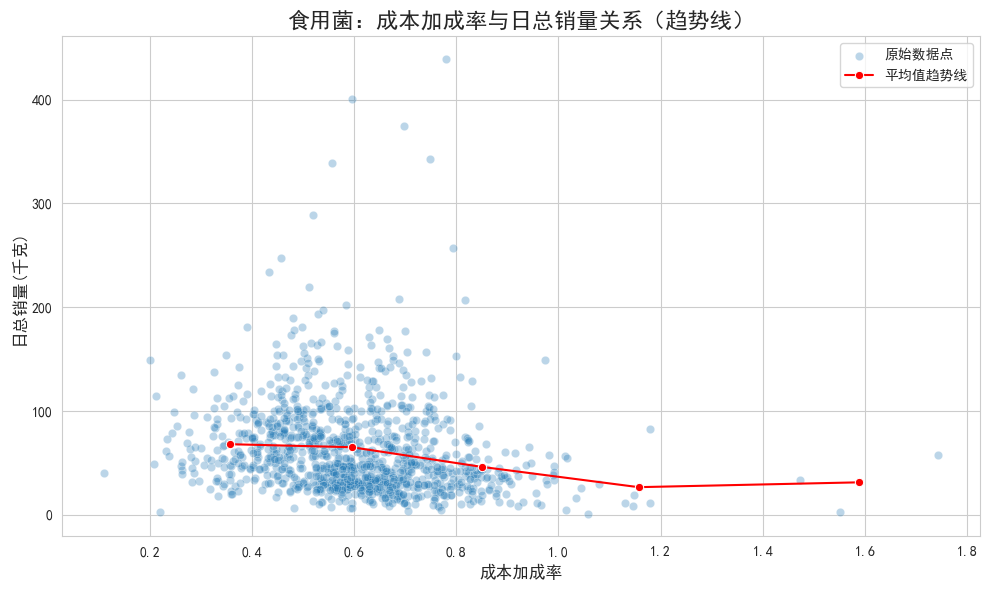


所有品类的成本加成率与总销量关系趋势图已生成。


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 设置绘图风格和中文显示
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用于正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用于正常显示负号

# 1. 数据准备：读取正确的数据文件
try:
    df_sales = pd.read_excel('含品类的销售流水明细.xlsx')
    df_cost = pd.read_excel('附件3.xlsx')
    
    df_sales['单品编码'] = df_sales['单品编码'].astype(str)
    df_cost['单品编码'] = df_cost['单品编码'].astype(str)
    
    df_sales['销售日期'] = pd.to_datetime(df_sales['销售日期'])
    df_cost.rename(columns={'日期': '销售日期'}, inplace=True)
    df_cost['销售日期'] = pd.to_datetime(df_cost['销售日期'])

    df_final = pd.merge(
        df_sales,
        df_cost,
        on=['销售日期', '单品编码'],
        how='left'
    )
    df_final['批发价格(元/千克)'].fillna(df_final['批发价格(元/千克)'].median(), inplace=True)

    print("数据加载与合并成功！")

except FileNotFoundError:
    print("文件未找到，请检查文件名和路径是否正确。")
    exit()

# 2. 计算成本加成率
df_final['总销量'] = df_final['销量(千克)']
df_final['总收入'] = df_final['销量(千克)'] * df_final['销售单价(元/千克)']
df_final['总成本'] = df_final['销量(千克)'] * df_final['批发价格(元/千克)']

# 按品类和销售日期进行聚合
df_daily_category_summary = df_final.groupby(['销售日期', '分类名称']).apply(
    lambda x: pd.Series({
        '平均销售单价': (x['总收入']).sum() / x['总销量'].sum(),
        '平均批发价格': (x['总成本']).sum() / x['总销量'].sum(),
        '日总销量': x['总销量'].sum()
    })
).reset_index()

df_daily_category_summary['成本加成率'] = (df_daily_category_summary['平均销售单价'] - df_daily_category_summary['平均批发价格']) / df_daily_category_summary['平均批发价格']


# 3. 优化分析：对成本加成率进行分桶并绘制趋势线
categories = df_daily_category_summary['分类名称'].unique()
num_bins = 5 # 分成5个区间

for category in categories:
    df_category = df_daily_category_summary[df_daily_category_summary['分类名称'] == category].copy()
    
    # 对成本加成率进行分桶
    df_category['加成率区间'] = pd.cut(df_category['成本加成率'], bins=num_bins, precision=2)
    
    # 计算每个区间内的平均销量和平均加成率
    df_binned = df_category.groupby('加成率区间').agg(
        平均销量=('日总销量', 'mean'),
        平均加成率=('成本加成率', 'mean')
    ).reset_index()

    # 绘制散点图和趋势线
    plt.figure(figsize=(10, 6))
    
    # 绘制原始散点图，作为背景
    sns.scatterplot(data=df_category, x='成本加成率', y='日总销量', alpha=0.3, label='原始数据点')
    
    # 绘制趋势线，连接每个分桶的平均值
    if len(df_binned) > 1:
        sns.lineplot(data=df_binned, x='平均加成率', y='平均销量', color='red', marker='o', label='平均值趋势线')
    
    plt.title(f'{category}：成本加成率与日总销量关系（趋势线）', fontsize=16)
    plt.xlabel('成本加成率', fontsize=12)
    plt.ylabel('日总销量(千克)', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\n所有品类的成本加成率与总销量关系趋势图已生成。")

In [7]:
import pandas as pd
import numpy as np

# 设置Pandas的显示选项，方便查看数据
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

def robust_read_excel(file_path):
    """
    健壮地读取Excel文件，并对列名进行清洗。
    """
    df = pd.read_excel(file_path)
    
    # 清洗列名：去除前后的空格和换行符
    df.columns = df.columns.str.strip()
    
    return df

# 1. 数据准备：读取所有数据文件
try:
    # 健壮地读取主销售数据
    df_sales = robust_read_excel('含品类的销售流水明细.xlsx')
    # 健壮地读取成本数据
    df_cost = robust_read_excel('附件3.xlsx')
    # 健壮地读取单品信息数据
    df_product_info = robust_read_excel('附件4.xlsx')

    print("数据文件加载成功！")
    print("-" * 50)
    print(f"df_sales 真实列名: {df_sales.columns.tolist()}")
    print(f"df_cost 真实列名: {df_cost.columns.tolist()}")
    print(f"df_product_info 真实列名: {df_product_info.columns.tolist()}")
    print("-" * 50)

except FileNotFoundError as e:
    print(f"文件未找到，请检查文件名和路径是否正确: {e}")
    exit()

# 2. 数据清洗与预处理
# 统一列名和数据类型，确保合并成功

# 统一日期列名
df_cost.rename(columns={'日期': '销售日期'}, inplace=True)

# 确保单品编码列为字符串类型
df_sales['单品编码'] = df_sales['单品编码'].astype(str)
df_cost['单品编码'] = df_cost['单品编码'].astype(str)

# 确保日期列为 datetime 类型
df_sales['销售日期'] = pd.to_datetime(df_sales['销售日期'])
df_cost['销售日期'] = pd.to_datetime(df_cost['销售日期'])

# 核心修正：处理df_product_info的列名
df_product_info.rename(
    columns={
        '小分类名称': '分类名称', 
        '平均损耗率(%)_小分类编码_不同值': '损耗率(%)'
    }, 
    inplace=True
)
print("df_product_info 列名已重命名为：", df_product_info.columns.tolist())
print("-" * 50)


# 3. 三表整合
# 3.1. 合并销售数据与成本数据 (左连接，保留所有销售记录)
df_merged = pd.merge(
    df_sales,
    df_cost,
    on=['销售日期', '单品编码'],
    how='left'
)

# 3.2. 合并上一步结果与处理后的df_product_info (左连接)
# 这里我们用'分类名称'作为合并键
df_sanheyi = pd.merge(
    df_merged,
    df_product_info[['分类名称', '损耗率(%)']],
    on='分类名称',
    how='left'
)

# 4. 打印新表信息
print("\n三表整合成功，新表 '三合一' 的前5行数据如下：")
print(df_sanheyi.head())
print("-" * 50)
print("\n'三合一' 表的列名如下：")
print(df_sanheyi.columns.tolist())

# 5. 处理缺失值（可选，但推荐）
df_sanheyi['批发价格(元/千克)'] = df_sanheyi.groupby('单品编码')['批发价格(元/千克)'].transform(lambda x: x.fillna(x.mean()))
df_sanheyi['损耗率(%)'] = df_sanheyi.groupby('分类名称')['损耗率(%)'].transform(lambda x: x.fillna(x.mean()))

# 6. 保存新表到Excel文件
file_name = '三合一.xlsx'
df_sanheyi.to_excel(file_name, index=False)
print(f"\n新表已保存为 '{file_name}' 文件。")

数据文件加载成功！
--------------------------------------------------
df_sales 真实列名: ['销售日期', '扫码销售时间', '单品编码', '销量(千克)', '销售单价(元/千克)', '销售类型', '是否打折销售', '分类名称']
df_cost 真实列名: ['日期', '单品编码', '批发价格(元/千克)']
df_product_info 真实列名: ['小分类编码', '小分类名称', '平均损耗率(%)_小分类编码_不同值']
--------------------------------------------------
df_product_info 列名已重命名为： ['小分类编码', '分类名称', '损耗率(%)']
--------------------------------------------------

三表整合成功，新表 '三合一' 的前5行数据如下：
        销售日期        扫码销售时间             单品编码  销量(千克)  销售单价(元/千克) 销售类型 是否打折销售  \
0 2020-07-01  09:15:07.924  102900005117056   0.396         7.6   销售      否   
1 2020-07-01  09:17:27.295  102900005115960   0.849         3.2   销售      否   
2 2020-07-01  09:17:33.905  102900005117056   0.409         7.6   销售      否   
3 2020-07-01  09:19:45.450  102900005115823   0.421        10.0   销售      否   
4 2020-07-01  09:20:23.686  102900005115908   0.539         8.0   销售      否   

  分类名称  批发价格(元/千克)  损耗率(%)  
0  辣椒类        4.32    9.24  
1  花叶类        2.10   12.83

‘三合一’数据表加载成功！
--------------------------------------------------
日度品类指标聚合与特征工程完成（前5行）：
        销售日期   分类名称     日总销量    日平均销售单价   日平均批发价格  是否有促销     成本加成率        星期几
0 2020-07-01  水生根茎类    4.119  10.000000  5.650000    0.0  0.769912  Wednesday
1 2020-07-01    花叶类  203.848   7.316028  4.830996    1.0  0.514393  Wednesday
2 2020-07-01    花菜类   47.076  12.716331  8.408452    0.0  0.512327  Wednesday
3 2020-07-01     茄类   33.942   5.040658  4.195221    0.0  0.201524  Wednesday
4 2020-07-01    辣椒类   72.332   8.943604  4.908218    0.0  0.822169  Wednesday
--------------------------------------------------


C:\Users\gongchencan\AppData\Local\Temp\ipykernel_25748\127627261.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_daily_category_summary = df_sanheyi.groupby(['销售日期', '分类名称']).apply(
C:\Users\gongchencan\AppData\Local\Temp\ipykernel_25748\127627261.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_daily_category_summary.fillna(method='ffill', inplace=True)
C:\Users\gongchencan\AppData\Local\Temp\ipykernel_25748\127627261.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_daily_category_summary.fil

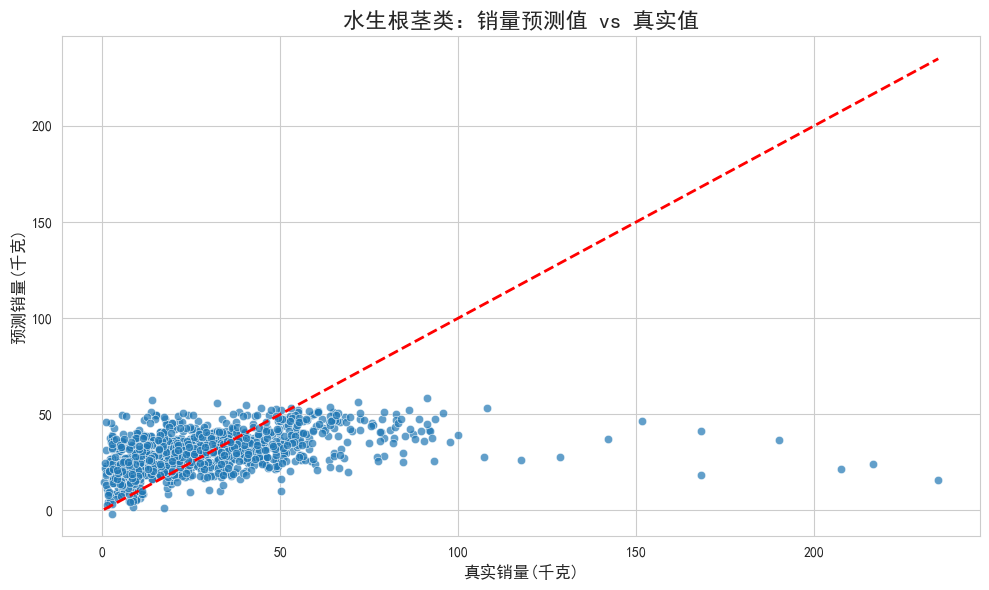

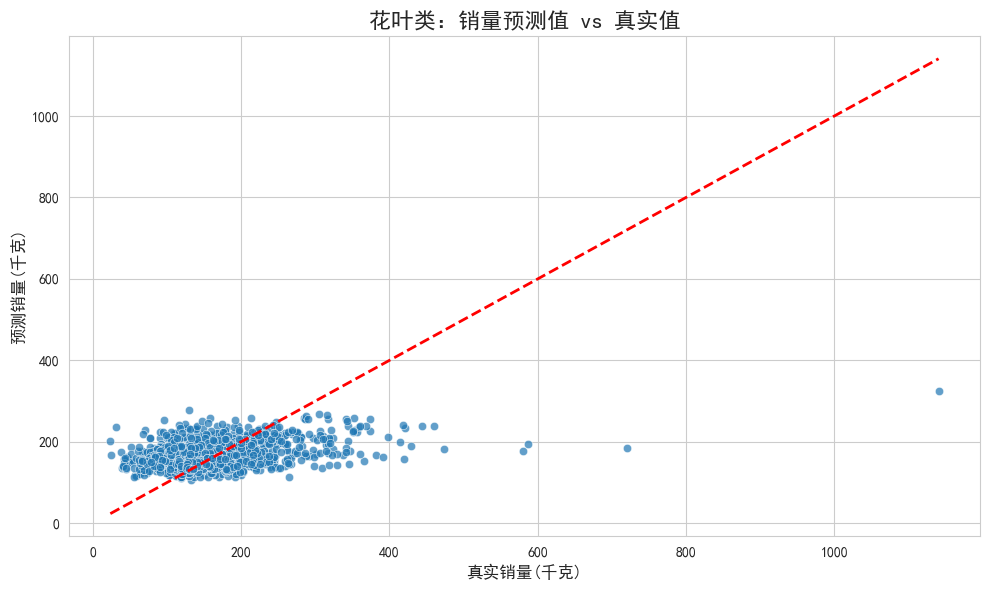

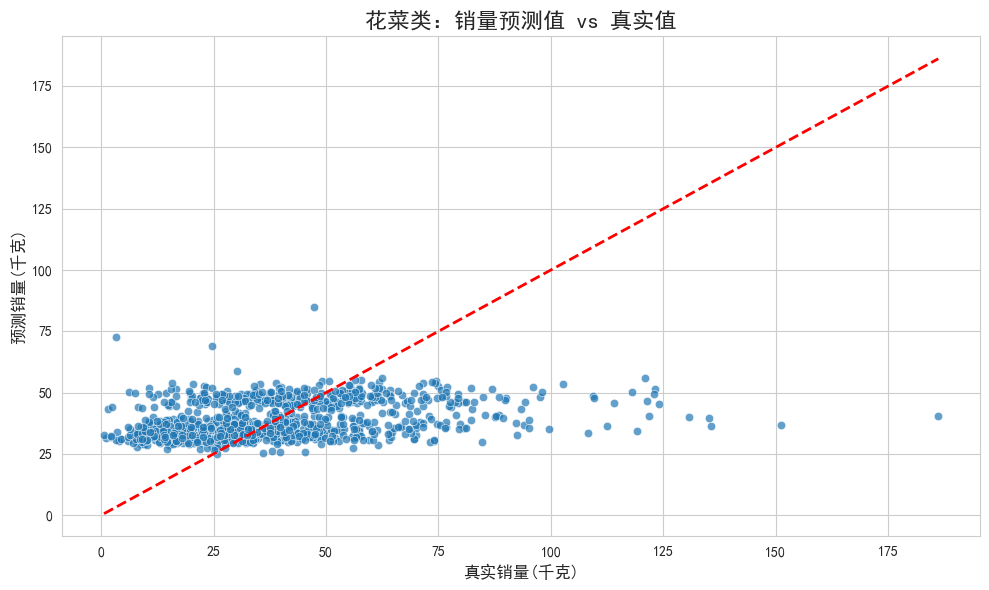

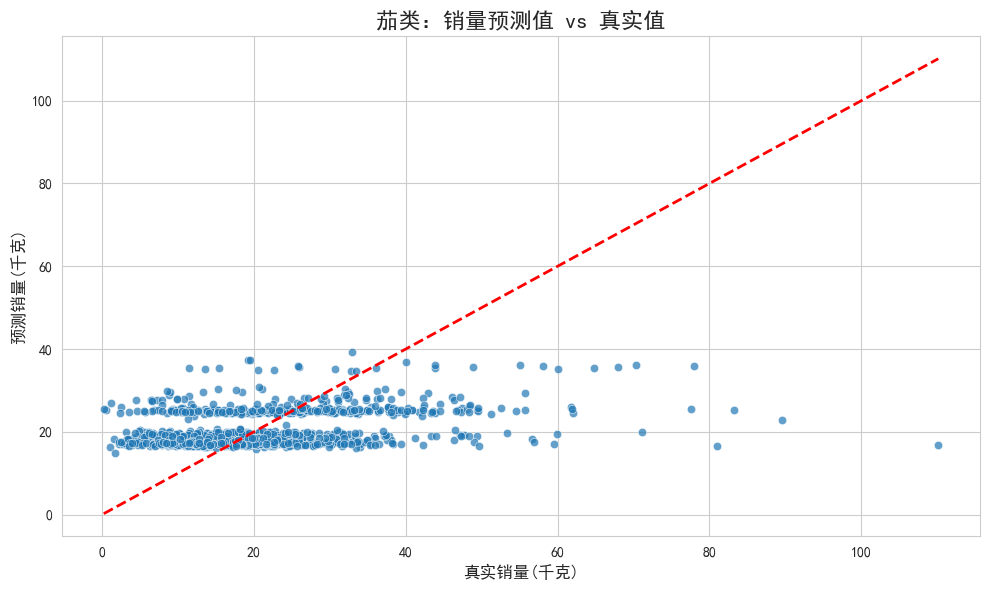

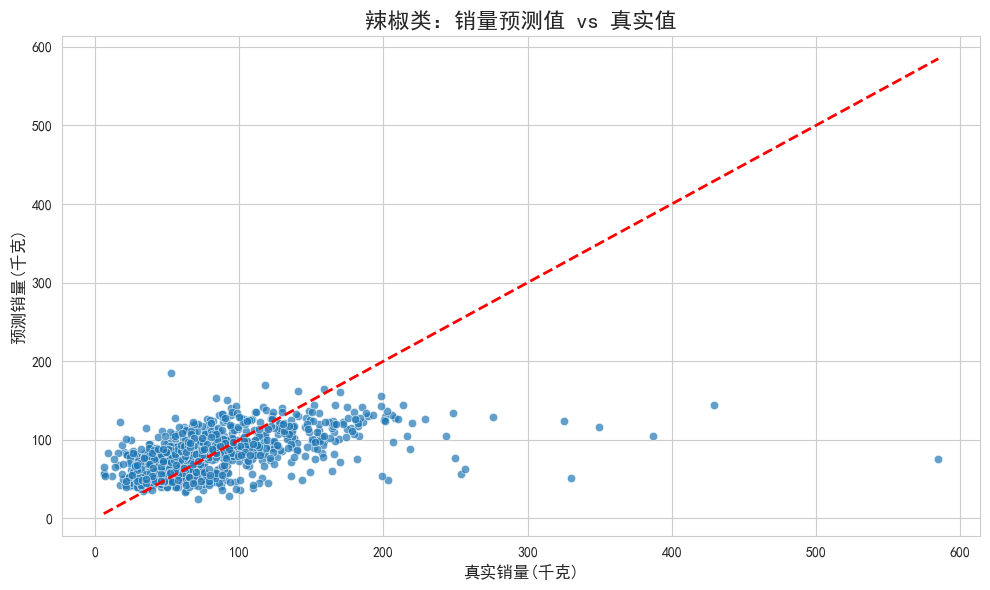

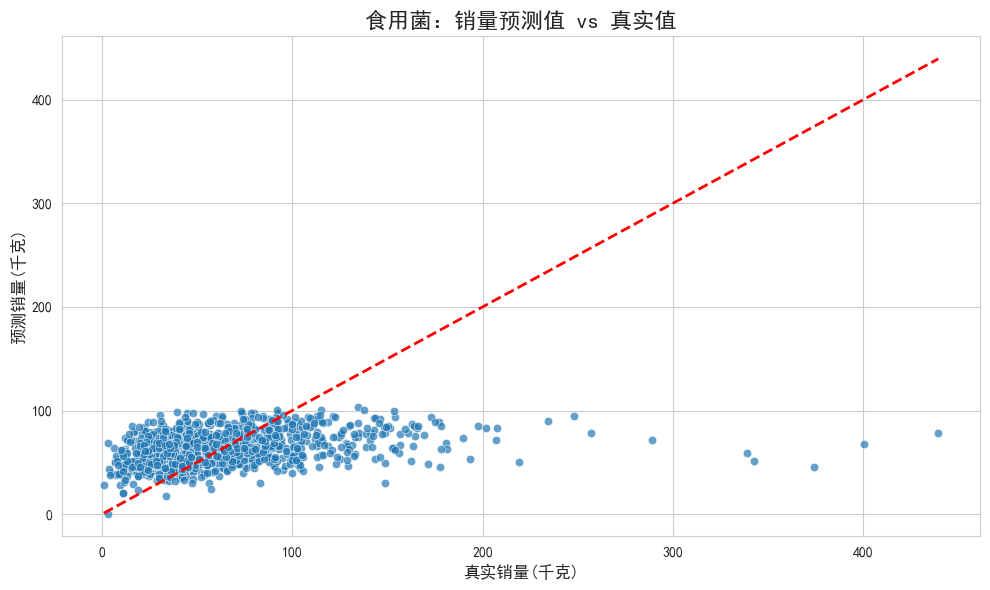

多元回归分析结果总结：
   品类   R²分数                                                                                                                                                                                                      回归模型系数
水生根茎类 0.1735  [-6.648218711023876, -0.11702327378568089, -4.328449334747504, 11.053391464693945, 7.997731379324235, -4.97886255703202, -3.9316729709945197, -5.695114707458435, -3.5514115990464896, 3.5514115990464887]
  花叶类 0.1677 [15.557443494887925, -6.7221955263753514, -14.03192862486976, 46.15271087935271, 33.571634517711495, -23.042418329251355, -20.226150241375052, -15.701652675192722, -12.818684758722267, 12.81868475872226]
  花菜类 0.1072    [3.028745730418252, -0.6939536902642705, -3.9634057028215666, 10.033581297690105, 9.786562307558945, -5.196006502615767, -5.240022014987977, -4.7267556945594675, -2.145784407871169, 2.145784407871171]
   茄类 0.1218    [0.563512095970903, -0.42302216200898535, -1.4595183830094731, 5.0456180211449135, 5.179607352709605, -2

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

# 设置绘图风格和中文显示
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用于正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用于正常显示负号

# 1. 数据准备：加载“三合一”数据表
try:
    df_sanheyi = pd.read_excel('三合一.xlsx')
    print("‘三合一’数据表加载成功！")
    print("-" * 50)
except FileNotFoundError:
    print("文件'三合一.xlsx'未找到，请确保已生成该文件。")
    exit()

# 2. 计算精确的日度指标
# 聚合为日度品类数据
df_daily_category_summary = df_sanheyi.groupby(['销售日期', '分类名称']).apply(
    lambda x: pd.Series({
        '日总销量': x['销量(千克)'].sum(),
        '日平均销售单价': (x['销量(千克)'] * x['销售单价(元/千克)']).sum() / x['销量(千克)'].sum(),
        '日平均批发价格': (x['销量(千克)'] * x['批发价格(元/千克)']).sum() / x['销量(千克)'].sum(),
        '是否有促销': (x['是否打折销售'] == '是').any().astype(int)
    })
).reset_index()

# 填充可能因销量为0而产生的NaN值
df_daily_category_summary.replace([np.inf, -np.inf], np.nan, inplace=True)
df_daily_category_summary.fillna(method='ffill', inplace=True)
df_daily_category_summary.fillna(method='bfill', inplace=True)

# 创建特征
df_daily_category_summary['成本加成率'] = (df_daily_category_summary['日平均销售单价'] - df_daily_category_summary['日平均批发价格']) / df_daily_category_summary['日平均批发价格']
df_daily_category_summary['星期几'] = df_daily_category_summary['销售日期'].dt.day_name() # 提取星期几

# 过滤掉成本加成率或销量为0或无穷大的异常值
df_daily_category_summary = df_daily_category_summary[(np.isfinite(df_daily_category_summary['成本加成率'])) & (df_daily_category_summary['日总销量'] > 0)]

print("日度品类指标聚合与特征工程完成（前5行）：")
print(df_daily_category_summary.head())
print("-" * 50)

# 3. 多元回归分析
categories = df_daily_category_summary['分类名称'].unique()
results_summary = []

# 定义特征和目标变量
numerical_features = ['成本加成率']
categorical_features = ['星期几', '是否有促销']

# 创建预处理管道，用于标准化数值特征和对分类特征进行独热编码
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

for category in categories:
    df_category = df_daily_category_summary[df_daily_category_summary['分类名称'] == category].copy()
    
    if len(df_category) < 20: # 增加数据点限制
        print(f"品类 {category} 的数据点过少，跳过回归分析。")
        continue

    X = df_category[numerical_features + categorical_features]
    y = df_category['日总销量']

    # 构建并训练模型管道
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])
    
    model_pipeline.fit(X, y)
    y_pred = model_pipeline.predict(X)
    r2 = r2_score(y, y_pred)
    
    # 存储结果
    results_summary.append({
        '品类': category,
        'R²分数': r2,
        '回归模型系数': model_pipeline.named_steps['regressor'].coef_
    })

    # 绘制预测值与真实值的对比图，移除R²分数
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y, y=y_pred, alpha=0.7)
    
    # 修复：移除R²分数，只保留标题
    plt.title(f'{category}：销量预测值 vs 真实值', fontsize=16)

    plt.xlabel('真实销量(千克)', fontsize=12)
    plt.ylabel('预测销量(千克)', fontsize=12)
    
    # 添加y=x线作为参考
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    plt.tight_layout()
    plt.show()

# 打印结果总结
df_results = pd.DataFrame(results_summary)
print("多元回归分析结果总结：")
print(df_results.to_string(index=False, float_format='%.4f'))

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from xgboost import XGBRegressor
from datetime import datetime, timedelta
from sklearn.metrics import r2_score, mean_squared_error

# 设置Pandas的显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 1. 数据准备与特征工程：加载“三合一”数据表
try:
    df_sanheyi = pd.read_excel('三合一.xlsx')
    print("‘三合一’数据表加载成功！")
    if '损耗率(%)' in df_sanheyi.columns:
        df_sanheyi['损耗率(%)'] = df_sanheyi['损耗率(%)'] / 100
        print("损耗率数据已修正，将百分数转换为小数。")
except FileNotFoundError:
    print("文件'三合一.xlsx'未找到，请确保已生成该文件。")
    exit()

df_sanheyi.fillna(method='ffill', inplace=True)
df_sanheyi.fillna(method='bfill', inplace=True)

df_daily_category_summary = df_sanheyi.groupby(['销售日期', '分类名称']).apply(
    lambda x: pd.Series({
        '日总销量': x['销量(千克)'].sum(),
        '日平均销售单价': (x['销量(千克)'] * x['销售单价(元/千克)']).sum() / x['销量(千克)'].sum(),
        '日平均批发价格': (x['销量(千克)'] * x['批发价格(元/千克)']).sum() / x['销量(千克)'].sum(),
        '日平均损耗率': x['损耗率(%)'].mean(),
        '是否打折销售_是': (x['是否打折销售'] == '是').any().astype(int)
    })
).reset_index()

df_daily_category_summary.replace([np.inf, -np.inf], np.nan, inplace=True)
df_daily_category_summary.fillna(method='ffill', inplace=True)
df_daily_category_summary.fillna(method='bfill', inplace=True)
df_daily_category_summary.dropna(inplace=True)

df_daily_category_summary['成本加成率'] = (df_daily_category_summary['日平均销售单价'] - df_daily_category_summary['日平均批发价格']) / df_daily_category_summary['日平均批发价格']
df_daily_category_summary['星期几'] = df_daily_category_summary['销售日期'].dt.dayofweek
df_daily_category_summary['月份'] = df_daily_category_summary['销售日期'].dt.month
# 新增特征：日期在月中的位置
df_daily_category_summary['日期'] = df_daily_category_summary['销售日期'].dt.day

# 核心改动：为每个品类生成滞后和滚动窗口特征
df_temp = pd.DataFrame()
categories = df_daily_category_summary['分类名称'].unique()
for category in categories:
    df_cat = df_daily_category_summary[df_daily_category_summary['分类名称'] == category].sort_values('销售日期').copy()
    
    # 滞后特征 (Lag Features)
    df_cat['日总销量_lag1'] = df_cat['日总销量'].shift(1)
    df_cat['日总销量_lag3'] = df_cat['日总销量'].shift(3)
    
    # 滚动窗口特征 (Rolling Window Features)
    df_cat['日总销量_rolling7d_mean'] = df_cat['日总销量'].rolling(window=7, min_periods=1).mean().shift(1)
    
    df_temp = pd.concat([df_temp, df_cat], ignore_index=True)

df_modeling = df_temp.dropna().copy()

# 定义用于建模的特征和目标变量
feature_columns = ['成本加成率', '星期几', '月份', '日期', '是否打折销售_是', '日总销量_lag1', '日总销量_lag3', '日总销量_rolling7d_mean']
target_column = '日总销量'


# 2. 为每个品类训练XGBoost模型，并使用GridSearchCV进行超参数调优
models = {}
evaluation_metrics_list = []

# 定义要搜索的超参数网格
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'reg_alpha': [0, 0.1, 0.5], # L1 正则化
    'reg_lambda': [1, 2] # L2 正则化
}

print("\n开始对每个品类进行超参数调优和模型训练...")
for category in categories:
    df_cat = df_modeling[df_modeling['分类名称'] == category].copy()
    if len(df_cat) < 50: # 确保有足够数据进行交叉验证
        continue
    X = df_cat[feature_columns]
    y = df_cat[target_column]

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    xgb_reg = XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42)

    grid_search = GridSearchCV(
        estimator=xgb_reg,
        param_grid=param_grid,
        scoring='r2',
        cv=cv,
        verbose=0
    )

    grid_search.fit(X, y)
    
    models[category] = grid_search.best_estimator_
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_
    
    evaluation_metrics_list.append({
        '品类': category,
        '最佳R² (CV)': best_score,
        '最佳超参数': best_params
    })
    
    print(f"品类 '{category}' 调优完成，最佳R²: {best_score:.4f}")

print("\n所有品类模型超参数调优完成。")
df_metrics = pd.DataFrame(evaluation_metrics_list)
print("模型交叉验证评估指标总结：")
print(df_metrics.to_string(index=False, float_format='%.4f'))
print("-" * 50)


# 3. 预测未来一周的最优补货量与定价策略
start_date = datetime(2023, 7, 1)
end_date = datetime(2023, 7, 7)
future_dates = pd.date_range(start=start_date, end=end_date, freq='D')
results = []

last_day_of_data = df_daily_category_summary['销售日期'].max()
df_last_week = df_daily_category_summary[df_daily_category_summary['销售日期'] > last_day_of_data - timedelta(days=7)]

for category in categories:
    if category not in models:
        continue
    
    predicted_sales_history = []
    
    avg_price = df_modeling[df_modeling['分类名称'] == category]['日平均批发价格'].mean()
    avg_loss_rate = df_modeling[df_modeling['分类名称'] == category]['日平均损耗率'].mean()
    
    for date in future_dates:
        day_of_week = date.weekday()
        month = date.month
        day = date.day

        if date == future_dates[0]:
            sales_history_for_lag = df_last_week[df_last_week['分类名称'] == category].sort_values('销售日期')
            lag1_sales = sales_history_for_lag['日总销量'].iloc[-1] if len(sales_history_for_lag) >= 1 else 0
            lag3_sales = sales_history_for_lag['日总销量'].iloc[-3] if len(sales_history_for_lag) >= 3 else 0
            rolling_7d_mean = sales_history_for_lag['日总销量'].rolling(window=7, min_periods=1).mean().iloc[-1] if len(sales_history_for_lag) >= 7 else sales_history_for_lag['日总销量'].mean()
        else:
            lag1_sales = predicted_sales_history[-1] if len(predicted_sales_history) >= 1 else 0
            lag3_sales = predicted_sales_history[-3] if len(predicted_sales_history) >= 3 else 0
            rolling_window_sales = list(sales_history_for_lag['日总销量'].iloc[-6:]) + predicted_sales_history
            if len(rolling_window_sales) >= 7:
                 rolling_7d_mean = pd.Series(rolling_window_sales).iloc[-7:].mean()
            else:
                 rolling_7d_mean = pd.Series(rolling_window_sales).mean()

        best_profit = -np.inf
        best_price_factor = 0.0
        best_sales = 0.0
        
        for price_factor in np.arange(-0.1, 1.01, 0.05):
            future_X = pd.DataFrame([{
                '成本加成率': price_factor,
                '星期几': day_of_week,
                '月份': month,
                '日期': day,
                '是否打折销售_是': 0,
                '日总销量_lag1': lag1_sales,
                '日总销量_lag3': lag3_sales,
                '日总销量_rolling7d_mean': rolling_7d_mean
            }])
            
            predicted_sales = models[category].predict(future_X)[0]
            if predicted_sales < 0: predicted_sales = 0
            
            selling_price = avg_price * (1 + price_factor)
            profit = (selling_price - (avg_price * (1 + avg_loss_rate))) * predicted_sales
            
            if profit > best_profit:
                best_profit = profit
                best_price_factor = price_factor
                best_sales = predicted_sales
        
        predicted_sales_history.append(best_sales)

        results.append({
            '日期': date.strftime('%Y-%m-%d'),
            '品类': category,
            '最优补货量(千克)': round(best_sales, 2),
            '最优成本加成率': round(best_price_factor, 2),
            '最优收益(元)': round(best_profit, 2)
        })

# 4. 整合并打印最终报告，并保存到Excel文件
df_results = pd.DataFrame(results)

# 核心改动：新增一列“最优售价”
df_avg_prices = df_daily_category_summary.groupby('分类名称')['日平均批发价格'].mean().reset_index()
df_results = pd.merge(df_results, df_avg_prices, left_on='品类', right_on='分类名称', how='left')
df_results['最优售价(元/千克)'] = df_results['日平均批发价格'] * (1 + df_results['最优成本加成率'])
df_results = df_results.drop(columns=['分类名称', '日平均批发价格'])

df_results.sort_values(by=['日期', '品类'], inplace=True)
print("\n未来一周(2023年7月1-7日)的最优补货量与定价策略：")
print(df_results)
print("-" * 50)
output_filename = '最优补货与定价策略_xgboost_dynamic.xlsx'
df_results.to_excel(output_filename, index=False)
print(f"最终结果已成功保存到文件：'{output_filename}'")

‘三合一’数据表加载成功！
损耗率数据已修正，将百分数转换为小数。


C:\Users\gongchencan\AppData\Local\Temp\ipykernel_8156\1554709209.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sanheyi.fillna(method='ffill', inplace=True)
C:\Users\gongchencan\AppData\Local\Temp\ipykernel_8156\1554709209.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sanheyi.fillna(method='bfill', inplace=True)
C:\Users\gongchencan\AppData\Local\Temp\ipykernel_8156\1554709209.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_daily_category_summary = df_sanheyi.groupby(['销售日期', '分类名称']).app


开始对每个品类进行超参数调优和模型训练...
品类 '水生根茎类' 调优完成，最佳R²: 0.5945
品类 '花叶类' 调优完成，最佳R²: 0.5303
品类 '花菜类' 调优完成，最佳R²: 0.5352
品类 '茄类' 调优完成，最佳R²: 0.5544
品类 '辣椒类' 调优完成，最佳R²: 0.6251
品类 '食用菌' 调优完成，最佳R²: 0.5972

所有品类模型超参数调优完成。
模型交叉验证评估指标总结：
   品类  最佳R² (CV)                                                                                           最佳超参数
水生根茎类     0.5945   {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 2}
  花叶类     0.5303 {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 2}
  花菜类     0.5352 {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.5, 'reg_lambda': 1}
   茄类     0.5544 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0.5, 'reg_lambda': 2}
  辣椒类     0.6251   {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 2}
  食用菌     0.5972 {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lamb

In [23]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from datetime import datetime, timedelta
from sklearn.metrics import r2_score

# 设置Pandas的显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 1. 数据准备与特征工程
try:
    df_sanheyi = pd.read_excel('三合一.xlsx')
    print("‘三合一’数据表加载成功！")
    if '损耗率(%)' in df_sanheyi.columns:
        df_sanheyi['损耗率(%)'] = df_sanheyi['损耗率(%)'] / 100
        print("损耗率数据已修正，将百分数转换为小数。")
except FileNotFoundError:
    print("文件'三合一.xlsx'未找到，请确保已生成该文件。")
    exit()

df_sanheyi.fillna(method='ffill', inplace=True)
df_sanheyi.fillna(method='bfill', inplace=True)

df_daily_category_summary = df_sanheyi.groupby(['销售日期', '分类名称']).apply(
    lambda x: pd.Series({
        '日总销量': x['销量(千克)'].sum(),
        '日平均销售单价': (x['销量(千克)'] * x['销售单价(元/千克)']).sum() / x['销量(千克)'].sum(),
        '日平均批发价格': (x['销量(千克)'] * x['批发价格(元/千克)']).sum() / x['销量(千克)'].sum(),
        '日平均损耗率': x['损耗率(%)'].mean(),
        '是否打折销售_是': (x['是否打折销售'] == '是').any().astype(int)
    })
).reset_index()

df_daily_category_summary.replace([np.inf, -np.inf], np.nan, inplace=True)
df_daily_category_summary.fillna(method='ffill', inplace=True)
df_daily_category_summary.fillna(method='bfill', inplace=True)
df_daily_category_summary.dropna(inplace=True)

df_daily_category_summary['成本加成率'] = (df_daily_category_summary['日平均销售单价'] - df_daily_category_summary['日平均批发价格']) / df_daily_category_summary['日平均批发价格']
df_daily_category_summary['星期几'] = df_daily_category_summary['销售日期'].dt.dayofweek
df_daily_category_summary['月份'] = df_daily_category_summary['销售日期'].dt.month

df_modeling = df_daily_category_summary[['分类名称', '成本加成率', '星期几', '月份', '是否打折销售_是', '日总销量', '日平均批发价格', '日平均损耗率']].copy()
df_modeling.dropna(inplace=True)

# 2. 为每个品类训练LightGBM模型
models = {}
r2_scores_list = []
categories = df_modeling['分类名称'].unique()

for category in categories:
    df_cat = df_modeling[df_modeling['分类名称'] == category].copy()
    if len(df_cat) < 10:
        continue
    X = df_cat[['成本加成率', '星期几', '月份', '是否打折销售_是']]
    y = df_cat['日总销量']
    
    # 使用 LightGBM 模型
    lgb_model = lgb.LGBMRegressor(objective='regression', n_estimators=100, learning_rate=0.1)
    lgb_model.fit(X, y)
    models[category] = lgb_model
    
    # 核心修正：计算并保存 R² 分数
    y_pred = lgb_model.predict(X)
    r2 = r2_score(y, y_pred)
    r2_scores_list.append({'品类': category, 'R²分数': r2})

print("\n所有品类 LightGBM 模型训练完成。")
df_r2_scores = pd.DataFrame(r2_scores_list)
print("模型 R² 分数总结：")
print(df_r2_scores.to_string(index=False, float_format='%.4f'))
print("-" * 50)

# 3. 预测未来一周的最优补货量与定价策略
start_date = datetime(2023, 7, 1)
end_date = datetime(2023, 7, 7)
future_dates = [start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)]
results = []
for category in categories:
    if category not in models:
        continue
    avg_price = df_modeling[df_modeling['分类名称'] == category]['日平均批发价格'].mean()
    avg_loss_rate = df_modeling[df_modeling['分类名称'] == category]['日平均损耗率'].mean()
    for date in future_dates:
        best_profit = -np.inf
        best_price_factor = 0.0
        best_sales = 0.0
        for price_factor in np.arange(-0.1, 1.01, 0.05):
            future_X = pd.DataFrame([{'成本加成率': price_factor,'星期几': date.weekday(),'月份': date.month,'是否打折销售_是': 0}])
            predicted_sales = models[category].predict(future_X)[0]
            if predicted_sales < 0: predicted_sales = 0
            selling_price = avg_price * (1 + price_factor)
            profit = (selling_price - (avg_price * (1 + avg_loss_rate))) * predicted_sales
            if profit > best_profit:
                best_profit = profit
                best_price_factor = price_factor
                best_sales = predicted_sales
        results.append({'日期': date.strftime('%Y-%m-%d'),'品类': category,'最优补货量(千克)': round(best_sales, 2),'最优成本加成率': round(best_price_factor, 2),'最优收益(元)': round(best_profit, 2)})

# 4. 整合并打印最终报告
df_results = pd.DataFrame(results)
df_results.sort_values(by=['日期', '品类'], inplace=True)
print("\n未来一周(2023年7月1-7日)的最优补货量与定价策略（LightGBM 版）：")
print(df_results)
print("-" * 50)
output_filename = '最优补货与定价策略_LightGBM.xlsx'
df_results.to_excel(output_filename, index=False)
print(f"最终结果已成功保存到文件：'{output_filename}'")

‘三合一’数据表加载成功！
损耗率数据已修正，将百分数转换为小数。


C:\Users\gongchencan\AppData\Local\Temp\ipykernel_25748\4003106696.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sanheyi.fillna(method='ffill', inplace=True)
C:\Users\gongchencan\AppData\Local\Temp\ipykernel_25748\4003106696.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sanheyi.fillna(method='bfill', inplace=True)
C:\Users\gongchencan\AppData\Local\Temp\ipykernel_25748\4003106696.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_daily_category_summary = df_sanheyi.groupby(['销售日期', '分类名称']).

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Number of data points in the train set: 1085, number of used features: 4
[LightGBM] [Info] Start training from score 30.325297
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Number of data points in the train set: 1085, number of used features: 4
[LightGBM] [Info] Start training from score 169.766217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Number of data points in the train set: 1078, number of used features: 4
[LightGBM] [Info] Start training 

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta

# 设置Pandas的显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# --- 1. 数据准备与特征工程：加载“三合一”数据表 ---
try:
    df_sanheyi = pd.read_excel('三合一.xlsx')
    print("‘三合一’数据表加载成功！")
    if '损耗率(%)' in df_sanheyi.columns:
        df_sanheyi['损耗率(%)'] = df_sanheyi['损耗率(%)'] / 100
        print("损耗率数据已修正，将百分数转换为小数。")
except FileNotFoundError:
    print("文件'三合一.xlsx'未找到，请确保已生成该文件。")
    exit()

df_sanheyi.fillna(method='ffill', inplace=True)
df_sanheyi.fillna(method='bfill', inplace=True)

df_daily_category_summary = df_sanheyi.groupby(['销售日期', '分类名称']).apply(
    lambda x: pd.Series({
        '日总销量': x['销量(千克)'].sum(),
        '日平均销售单价': (x['销量(千克)'] * x['销售单价(元/千克)']).sum() / x['销量(千克)'].sum(),
        '日平均批发价格': (x['销量(千克)'] * x['批发价格(元/千克)']).sum() / x['销量(千克)'].sum(),
        '日平均损耗率': x['损耗率(%)'].mean(),
        '是否打折销售_是': (x['是否打折销售'] == '是').any().astype(int)
    })
).reset_index()

df_daily_category_summary.replace([np.inf, -np.inf], np.nan, inplace=True)
df_daily_category_summary.fillna(method='ffill', inplace=True)
df_daily_category_summary.fillna(method='bfill', inplace=True)
df_daily_category_summary.dropna(inplace=True)

df_daily_category_summary['成本加成率'] = (df_daily_category_summary['日平均销售单价'] - df_daily_category_summary['日平均批发价格']) / df_daily_category_summary['日平均批发价格']
df_daily_category_summary['星期几'] = df_daily_category_summary['销售日期'].dt.dayofweek
df_daily_category_summary['月份'] = df_daily_category_summary['销售日期'].dt.month

# --- 2. 为每个品类训练 LSTM 模型 ---
models = {}
scalers = {}
sequence_length = 7  # 使用过去7天的数据来预测第8天

for category in df_daily_category_summary['分类名称'].unique():
    df_cat = df_daily_category_summary[df_daily_category_summary['分类名称'] == category].copy()
    df_cat.sort_values('销售日期', inplace=True)

    if len(df_cat) < sequence_length + 2:
        print(f"警告：跳过 '{category}' 品类，数据点（{len(df_cat)}）不足，无法构建时序序列。")
        continue

    # 定义用于 LSTM 的特征
    features_to_scale = ['日总销量', '成本加成率', '星期几', '月份', '是否打折销售_是']
    
    # 对特征进行归一化，这是神经网络的关键步骤
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df_cat[features_to_scale])
    scalers[category] = scaler

    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i : i + sequence_length])
        y.append(scaled_data[i + sequence_length, 0])  # 第0列是 '日总销量'

    X, y = np.array(X), np.array(y)

    # 构建 LSTM 模型
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(50, return_sequences=False, input_shape=(sequence_length, len(features_to_scale))),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # 训练模型
    print(f"正在训练 '{category}' 品类 LSTM 模型...")
    model.fit(X, y, epochs=50, batch_size=32, verbose=0)
    models[category] = model

# --- 3. 预测未来一周的最优补货量与定价策略 ---
start_date = datetime(2023, 7, 1)
end_date = datetime(2023, 7, 7)
future_dates = [start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)]

results = []
for category in models.keys():
    df_cat = df_daily_category_summary[df_daily_category_summary['分类名称'] == category].copy()
    avg_price = df_cat['日平均批发价格'].mean()
    avg_loss_rate = df_cat['日平均损耗率'].mean()
    
    current_data = df_cat.sort_values('销售日期').tail(sequence_length)[features_to_scale]

    for date in future_dates:
        best_profit = -np.inf
        best_price_factor = 0.0
        best_sales = 0.0
        
        for price_factor in np.arange(-0.1, 1.01, 0.05):
            # 模拟下一天的数据
            new_features = [
                0, # 销量未知，用0占位
                price_factor,
                date.weekday(),
                date.month,
                0 # 假设不打折
            ]
            
            # 将新数据添加到序列中，准备预测
            future_data_to_scale = pd.concat([current_data, pd.DataFrame([new_features], columns=features_to_scale)])
            scaled_future_data = scalers[category].transform(future_data_to_scale)
            
            # 使用最后7天的数据进行预测
            prediction_input = np.array([scaled_future_data[-sequence_length:]])
            predicted_scaled_sales = models[category].predict(prediction_input, verbose=0)[0, 0]
            
            # 反归一化，得到真实销量
            predicted_sales_array = np.array([[predicted_scaled_sales, 0, 0, 0, 0]])
            predicted_sales = scalers[category].inverse_transform(predicted_sales_array)[0, 0]
            
            if predicted_sales < 0: predicted_sales = 0

            selling_price = avg_price * (1 + price_factor)
            profit = (selling_price - (avg_price * (1 + avg_loss_rate))) * predicted_sales
            
            if profit > best_profit:
                best_profit = profit
                best_price_factor = price_factor
                best_sales = predicted_sales
                
        results.append({
            '日期': date.strftime('%Y-%m-%d'),
            '品类': category,
            '最优补货量(千克)': round(best_sales, 2),
            '最优成本加成率': round(best_price_factor, 2),
            '最优收益(元)': round(best_profit, 2)
        })
        
        # 模拟数据更新，以便预测下一天
        next_day_features = [
            best_sales, # 用预测的最优销量来作为下一天的历史数据
            best_price_factor,
            date.weekday(),
            date.month,
            0
        ]
        
        next_day_df = pd.DataFrame([next_day_features], columns=features_to_scale)
        current_data = pd.concat([current_data.iloc[1:], next_day_df])
        
# --- 4. 整合并打印最终报告 ---
df_results = pd.DataFrame(results)
df_results.sort_values(by=['日期', '品类'], inplace=True)
output_filename = '最优补货与定价策略_LSTM.xlsx'

print("\n未来一周(2023年7月1-7日)的最优补货量与定价策略（LSTM 版）：")
print(df_results)
print("-" * 50)

df_results.to_excel(output_filename, index=False)
print(f"最终结果已成功保存到文件：'{output_filename}'")

‘三合一’数据表加载成功！
损耗率数据已修正，将百分数转换为小数。


C:\Users\gongchencan\AppData\Local\Temp\ipykernel_23664\1071325810.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sanheyi.fillna(method='ffill', inplace=True)
C:\Users\gongchencan\AppData\Local\Temp\ipykernel_23664\1071325810.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sanheyi.fillna(method='bfill', inplace=True)
C:\Users\gongchencan\AppData\Local\Temp\ipykernel_23664\1071325810.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_daily_category_summary = df_sanheyi.groupby(['销售日期', '分类名称']).

正在训练 '水生根茎类' 品类 LSTM 模型...


c:\Users\gongchencan\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


正在训练 '花叶类' 品类 LSTM 模型...


c:\Users\gongchencan\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


正在训练 '花菜类' 品类 LSTM 模型...


c:\Users\gongchencan\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


正在训练 '茄类' 品类 LSTM 模型...


c:\Users\gongchencan\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


正在训练 '辣椒类' 品类 LSTM 模型...


c:\Users\gongchencan\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


正在训练 '食用菌' 品类 LSTM 模型...

未来一周(2023年7月1-7日)的最优补货量与定价策略（LSTM 版）：
            日期     品类  最优补货量(千克)  最优成本加成率  最优收益(元)
0   2023-07-01  水生根茎类      17.77     1.00    92.77
7   2023-07-01    花叶类     149.03     1.00   441.13
14  2023-07-01    花菜类      14.19     1.00    74.07
21  2023-07-01     茄类      17.40     1.00    90.65
28  2023-07-01    辣椒类      92.57     1.00   428.45
35  2023-07-01    食用菌      29.91     1.00   113.25
1   2023-07-02  水生根茎类       6.15     1.00    32.13
8   2023-07-02    花叶类      86.89     1.00   257.20
15  2023-07-02    花菜类       2.19     0.75     8.06
22  2023-07-02     茄类      10.04     1.00    52.33
29  2023-07-02    辣椒类      48.74     1.00   225.57
36  2023-07-02    食用菌       3.18     0.60     6.72
2   2023-07-03  水生根茎类       6.84     1.00    35.73
9   2023-07-03    花叶类      96.43     1.00   285.41
16  2023-07-03    花菜类       4.38     1.00    22.89
23  2023-07-03     茄类       8.53     1.00    44.46
30  2023-07-03    辣椒类      43.18     1.00   199.84
37  2023-07-03    